# Step 3: Ingest Data into the SwimContainer

This notebook demonstrates how to ingest extracted data into the SwimContainer. The container provides a unified `ingest` API for all data sources:

- `container.ingest.ndvi()` - NDVI from Earth Engine exports
- `container.ingest.etf()` - ETf from SSEBop or other models
- `container.ingest.gridmet()` - Meteorology
- `container.ingest.snodas()` - Snow water equivalent
- `container.ingest.properties()` - Soils, LULC, irrigation

## Two Data Sources

1. **Extracted data**: If you ran notebook 02, data is in `data/remote_sensing/landsat/extracts/`, `data/snow/snodas/extracts/`, etc.
2. **Pre-built data**: If you don't have Earth Engine access, use data from `data/prebuilt/`

Set `USE_PREBUILT = True` or `False` below to choose your data source.

In [1]:
import os
import sys
from pathlib import Path

root = os.path.abspath("../..")
sys.path.append(root)

from swimrs.container import open_container
from swimrs.swim.config import ProjectConfig

## 1. Configuration

Choose whether to use pre-built data or extracted data.

In [2]:
# Set to True to use pre-built data, False to use data from notebook 02
USE_PREBUILT = False

project_dir = Path.cwd()
data_dir = project_dir / "data"
container_path = data_dir / "1_Boulder.swim"

# Load config to get feature_id and gridmet mapping
config_path = project_dir / "1_Boulder.toml"
config = ProjectConfig()
config.read_config(str(config_path))
feature_id = config.feature_id_col

# GridMET requires a UID-to-GFID mapping shapefile
gridmet_shapefile = config.gridmet_mapping_shp

print(f"Using feature_id column: {feature_id}")
print(f"GridMET mapping shapefile: {gridmet_shapefile}")

if USE_PREBUILT:
    print("Using pre-built data from data/prebuilt/")
    ndvi_root = data_dir / "prebuilt" / "remote_sensing" / "landsat" / "extracts" / "ndvi"
    sentinel_ndvi_root = data_dir / "prebuilt" / "remote_sensing" / "sentinel" / "extracts" / "ndvi"
    etf_root = data_dir / "prebuilt" / "remote_sensing" / "landsat" / "extracts" / "ssebop_etf"
    met_dir = data_dir / "prebuilt" / "met_timeseries" / "gridmet"
    snodas_dir = data_dir / "prebuilt" / "snow" / "snodas" / "extracts"
    properties_dir = data_dir / "prebuilt" / "properties"
else:
    print("Using extracted data from notebook 02")
    ndvi_root = data_dir / "remote_sensing" / "landsat" / "extracts" / "ndvi"
    sentinel_ndvi_root = data_dir / "remote_sensing" / "sentinel" / "extracts" / "ndvi"
    etf_root = data_dir / "remote_sensing" / "landsat" / "extracts" / "ssebop_etf"
    met_dir = data_dir / "met_timeseries" / "gridmet"
    snodas_dir = data_dir / "snow" / "snodas" / "extracts"
    properties_dir = data_dir / "properties"

Using feature_id column: FID_1
GridMET mapping shapefile: /home/dgketchum/code/swim-rs/examples/1_Boulder/data/gis/mt_sid_boulder_gfid.shp
Using extracted data from notebook 02


## 2. Open the Container

Open the container we created in notebook 01 in read-write mode.

In [3]:
container = open_container(str(container_path), mode="r+")

print(f"Opened container: {container.project_name}")
print(f"Fields: {container.n_fields}")
print(f"Date range: {container.start_date} to {container.end_date}")

Opened container: 1_Boulder
Fields: 78
Date range: 2004-01-01 00:00:00 to 2022-12-31 00:00:00


## 3. Check Current Status

Before ingestion, let's see what data the container currently holds.

In [4]:
print(container.query.status())

CONTAINER STATUS
  URI: file:///home/dgketchum/code/swim-rs/examples/1_Boulder/data/1_Boulder.swim
  Storage: directory
  Fields: 78
  Date range: 2004-01-01 to 2022-12-31
  Days: 6940

DATA PATHS:
----------------------------------------

  derived/
    combined_ndvi/inv_irr: shape=(6940, 78), 5.5% valid
    combined_ndvi/irr: shape=(6940, 78), 6.5% valid
    dynamics/gwsub_data: shape=(78,), 100.0% non-empty
    dynamics/irr_data: shape=(78,), 100.0% non-empty
    dynamics/kc_max: shape=(78,), 100.0% valid
    dynamics/ke_max: shape=(78,), 100.0% valid

  geometry/
    area_m2: shape=(78,), 100.0% valid
    lat: shape=(78,), 100.0% valid
    lon: shape=(78,), 100.0% valid
    properties/COUNTYNAME: shape=(78,), 100.0% non-empty
    properties/COUNTY_NO: shape=(78,), 100.0% valid
    properties/ITYPE: shape=(78,), 100.0% non-empty
    properties/MAPPEDBY: shape=(78,), 100.0% non-empty
    properties/New_Acres: shape=(78,), 100.0% valid
    properties/SOURCECODE: shape=(78,), 100.0% no

## 4. Ingest NDVI Data

Ingest NDVI for both irrigated (`irr`) and non-irrigated (`inv_irr`) masks.

In [5]:
for mask in ["irr", "inv_irr"]:
    ndvi_dir = ndvi_root / mask
    if ndvi_dir.exists():
        print(f"Ingesting NDVI ({mask})...")
        container.ingest.ndvi(
            source_dir=str(ndvi_dir),
            uid_column=feature_id,
            instrument="landsat",
            mask=mask,
            overwrite=True,
        )
    else:
        print(f"Warning: NDVI directory not found: {ndvi_dir}")

Ingesting NDVI (irr)...
Ingesting NDVI (inv_irr)...


## 4b. Ingest Sentinel-2 NDVI Data

Sentinel-2 NDVI complements Landsat with higher spatial resolution (10m) and different revisit timing. Data is only available from 2015 onwards.

In [6]:
for mask in ["irr", "inv_irr"]:
    sentinel_ndvi_dir = sentinel_ndvi_root / mask
    if sentinel_ndvi_dir.exists():
        print(f"Ingesting Sentinel-2 NDVI ({mask})...")
        container.ingest.ndvi(
            source_dir=str(sentinel_ndvi_dir),
            uid_column=feature_id,
            instrument="sentinel",
            mask=mask,
            overwrite=True,
        )
    else:
        print(f"Sentinel-2 NDVI not found: {sentinel_ndvi_dir} (expected for pre-2015 data)")

Ingesting Sentinel-2 NDVI (irr)...
Ingesting Sentinel-2 NDVI (inv_irr)...


## 5. Ingest ETf Data

Ingest SSEBop ETf for both masks.

In [7]:
for mask in ["irr", "inv_irr"]:
    etf_dir = etf_root / mask
    if etf_dir.exists():
        print(f"Ingesting ETf ({mask})...")
        container.ingest.etf(
            source_dir=str(etf_dir),
            uid_column=feature_id,
            instrument="landsat",
            model="ssebop",
            mask=mask,
            overwrite=True,
        )
    else:
        print(f"Warning: ETf directory not found: {etf_dir}")

Ingesting ETf (irr)...
Ingesting ETf (inv_irr)...


## 6. Ingest Meteorology Data

Ingest GridMET meteorology including bias-corrected reference ET.

In [7]:
if met_dir.exists():
    print("Ingesting GridMET meteorology...")
    container.ingest.gridmet(
        source_dir=str(met_dir),
        grid_shapefile=str(gridmet_shapefile),
        uid_column=feature_id,
        grid_column=config.gridmet_id_col,
        variables=["eto", "etr", "prcp", "tmin", "tmax", "srad", "u2", "ea"],
        include_corrected=True,
        overwrite=True,
    )
else:
    print(f"Warning: GridMET directory not found: {met_dir}")

Ingesting GridMET meteorology...


## 7. Ingest Snow Data (SNODAS)

Ingest SNODAS snow water equivalent.

In [8]:
if snodas_dir.exists():
    print("Ingesting SNODAS SWE...")
    container.ingest.snodas(source_dir=str(snodas_dir), uid_column=feature_id, overwrite=True)
else:
    print(f"Warning: SNODAS directory not found: {snodas_dir}")

Ingesting SNODAS SWE...


## 8. Ingest Properties

Ingest static properties: soils, land cover, and irrigation fractions.

In [9]:
soils_csv = properties_dir / "1_Boulder_ssurgo.csv"
lulc_csv = properties_dir / "1_Boulder_landcover.csv"
irr_csv = properties_dir / "1_Boulder_irr.csv"

# Check which files exist
props_exist = {
    "soils": soils_csv.exists(),
    "lulc": lulc_csv.exists(),
    "irrigation": irr_csv.exists(),
}

if any(props_exist.values()):
    print("Ingesting properties...")
    container.ingest.properties(
        soils_csv=str(soils_csv) if props_exist["soils"] else None,
        lulc_csv=str(lulc_csv) if props_exist["lulc"] else None,
        irr_csv=str(irr_csv) if props_exist["irrigation"] else None,
        uid_column=feature_id,
        overwrite=True,
    )
    print(f"  Soils: {'OK' if props_exist['soils'] else 'not found'}")
    print(f"  Land cover: {'OK' if props_exist['lulc'] else 'not found'}")
    print(f"  Irrigation: {'OK' if props_exist['irrigation'] else 'not found'}")
else:
    print(f"Warning: No property files found in {properties_dir}")

Ingesting properties...
  Soils: OK
  Land cover: OK
  Irrigation: OK


## 9. Check Container Status After Ingestion

In [8]:
print(container.query.status(detailed=True))

CONTAINER STATUS
  URI: file:///home/dgketchum/code/swim-rs/examples/1_Boulder/data/1_Boulder.swim
  Storage: directory
  Fields: 78
  Date range: 2004-01-01 to 2022-12-31
  Days: 6940

DATA PATHS:
----------------------------------------

  derived/
    combined_ndvi/inv_irr: shape=(6940, 78), 5.5% valid
    combined_ndvi/irr: shape=(6940, 78), 6.5% valid
    dynamics/gwsub_data: shape=(78,), 100.0% non-empty
    dynamics/irr_data: shape=(78,), 100.0% non-empty
    dynamics/kc_max: shape=(78,), 100.0% valid
    dynamics/ke_max: shape=(78,), 100.0% valid

  geometry/
    area_m2: shape=(78,), 100.0% valid
    lat: shape=(78,), 100.0% valid
    lon: shape=(78,), 100.0% valid
    properties/COUNTYNAME: shape=(78,), 100.0% non-empty
    properties/COUNTY_NO: shape=(78,), 100.0% valid
    properties/ITYPE: shape=(78,), 100.0% non-empty
    properties/MAPPEDBY: shape=(78,), 100.0% non-empty
    properties/New_Acres: shape=(78,), 100.0% valid
    properties/SOURCECODE: shape=(78,), 100.0% no

## 10. Explore Ingested Data with xarray

One of the powerful features of the SwimContainer is seamless xarray integration. Let's visualize some of the ingested data.

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
# Get NDVI as an xarray DataArray
try:
    ndvi = container.to_xarray("remote_sensing/ndvi/landsat/irr")
    print(f"NDVI shape: {ndvi.shape}")
    print(f"Dimensions: {ndvi.dims}")
    print(f"Sites: {list(ndvi.site.values[:5])}...")
except Exception as e:
    print(f"Could not load NDVI: {e}")

NDVI shape: (6940, 78)
Dimensions: ('time', 'site')
Sites: [np.str_('043_000153'), np.str_('043_000154'), np.str_('043_000155'), np.str_('043_000156'), np.str_('043_000157')]...


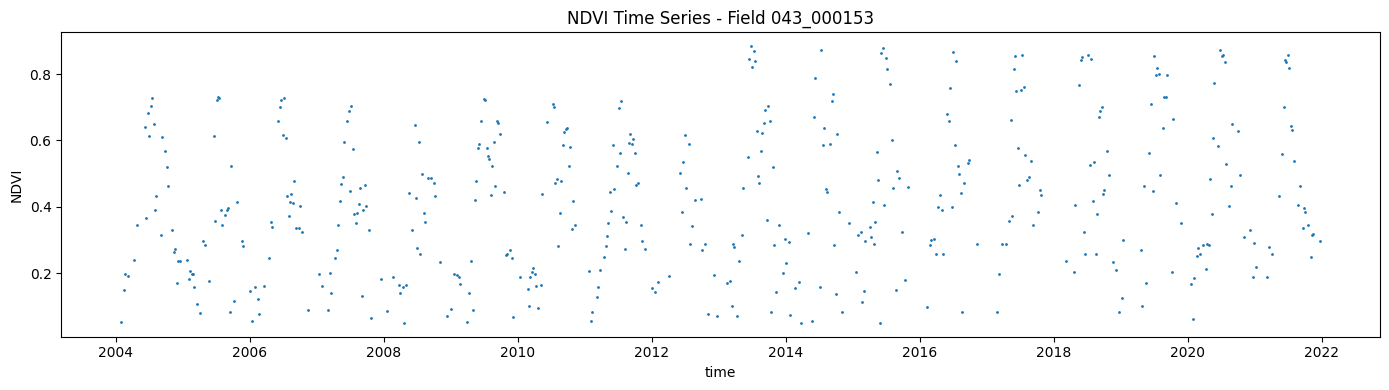

In [12]:
# Plot NDVI time series for a single field
try:
    sample_site = container.field_uids[0]
    ndvi_site = ndvi.sel(site=sample_site)

    fig, ax = plt.subplots(figsize=(14, 4))
    ndvi_site.plot(ax=ax, marker=".", linestyle="none", markersize=2)
    ax.set_title(f"NDVI Time Series - Field {sample_site}")
    ax.set_ylabel("NDVI")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot NDVI: {e}")

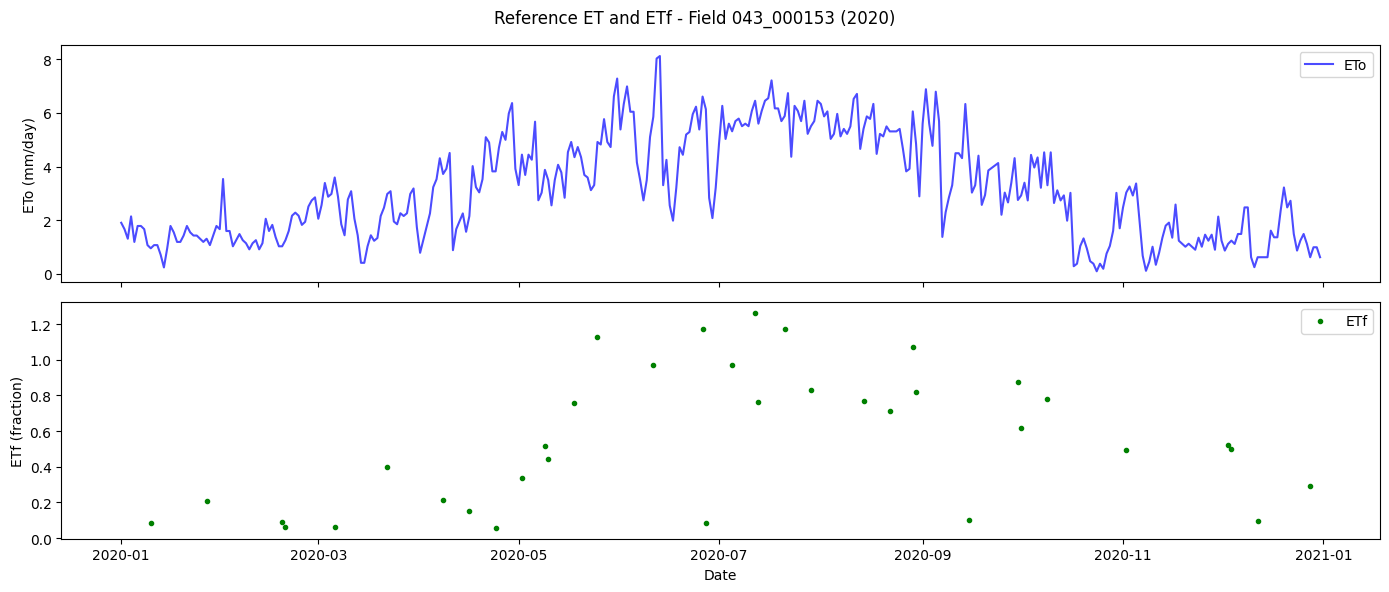

In [13]:
# Plot ETf vs ETo for a single year
try:
    etf = container.to_xarray("remote_sensing/etf/landsat/ssebop/irr")
    eto = container.to_xarray("meteorology/gridmet/eto_corr")

    # Select one site and one year
    sample_site = container.field_uids[0]
    etf_2020 = etf.sel(site=sample_site, time="2020")
    eto_2020 = eto.sel(site=sample_site, time="2020")

    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    axes[0].plot(eto_2020.time, eto_2020, "b-", alpha=0.7, label="ETo")
    axes[0].set_ylabel("ETo (mm/day)")
    axes[0].legend()

    axes[1].plot(etf_2020.time, etf_2020, "go", markersize=3, label="ETf")
    axes[1].set_ylabel("ETf (fraction)")
    axes[1].set_xlabel("Date")
    axes[1].legend()

    fig.suptitle(f"Reference ET and ETf - Field {sample_site} (2020)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot ETf/ETo: {e}")

## 11. View Provenance

The container automatically tracks all operations for reproducibility.

In [16]:
print("Provenance Log:")
for event in container.provenance.events[-10:]:
    print(f"  {event.timestamp[:19]} - {event.operation}: {event.target or 'container'}")

Provenance Log:
  2026-01-13T04:13:59 - ingest: meteorology/gridmet
  2026-01-13T04:14:47 - ingest: snow/snodas/swe
  2026-01-13T04:14:49 - ingest: properties
  2026-01-13T18:42:59 - ingest: remote_sensing/etf/landsat/ssebop/irr
  2026-01-13T18:44:34 - ingest: remote_sensing/ndvi/landsat/irr
  2026-01-13T18:44:42 - ingest: remote_sensing/ndvi/landsat/inv_irr
  2026-01-13T18:44:46 - ingest: remote_sensing/ndvi/sentinel/irr
  2026-01-13T18:44:50 - ingest: remote_sensing/ndvi/sentinel/inv_irr
  2026-01-13T18:44:57 - ingest: remote_sensing/etf/landsat/ssebop/irr
  2026-01-13T18:45:03 - ingest: remote_sensing/etf/landsat/ssebop/inv_irr


## 12. Save and Close

In [17]:
container.save()
container.close()

print(f"Container saved to: {container_path}")
print("\nNext: Run notebook 04 to compute dynamics and export model inputs")

Container saved to: /home/dgketchum/code/swim-rs/examples/1_Boulder/data/1_Boulder.swim

Next: Run notebook 04 to compute dynamics and export model inputs
